In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
with gzip.open('../data/chembl_5HT.csv.gz') as inf:
    d = pd.read_csv(inf)
d.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


Get some info about those assays:

In [56]:
import requests,json
assay_lookup = {}
tpls = sorted([(len(v),k) for k,v in d.groupby('target_chembl_id').groups.items()],reverse=True)
for v,k in tpls:
    resp=requests.get(f'https://www.ebi.ac.uk/chembl/api/data/target/{k}?format=json')
    info = json.loads(resp.text)
    assay_lookup[k] = info['organism'],info['pref_name']
    print(k,v,info['organism'],info['pref_name'])

CHEMBL3371 3180 Homo sapiens Serotonin 6 (5-HT6) receptor
CHEMBL224 3068 Homo sapiens Serotonin 2a (5-HT2a) receptor
CHEMBL214 2672 Homo sapiens Serotonin 1a (5-HT1a) receptor
CHEMBL3155 1636 Homo sapiens Serotonin 7 (5-HT7) receptor
CHEMBL225 1580 Homo sapiens Serotonin 2c (5-HT2c) receptor
CHEMBL1833 922 Homo sapiens Serotonin 2b (5-HT2b) receptor
CHEMBL1898 542 Homo sapiens Serotonin 1b (5-HT1b) receptor
CHEMBL1983 525 Homo sapiens Serotonin 1d (5-HT1d) receptor
CHEMBL1899 491 Homo sapiens Serotonin 3a (5-HT3a) receptor
CHEMBL1875 369 Homo sapiens Serotonin 4 (5-HT4) receptor
CHEMBL3426 227 Homo sapiens Serotonin 5a (5-HT5a) receptor
CHEMBL2182 86 Homo sapiens Serotonin 1e (5-HT1e) receptor
CHEMBL1805 36 Homo sapiens Serotonin 1f (5-HT1f) receptor


Look at some distributions of activities

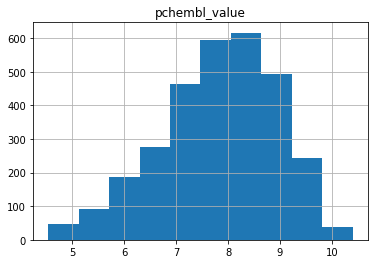

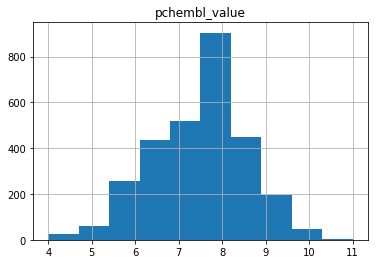

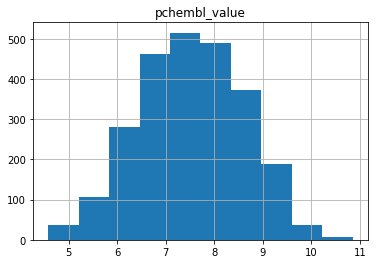

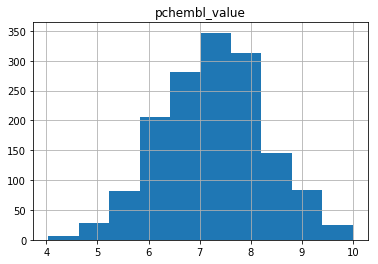

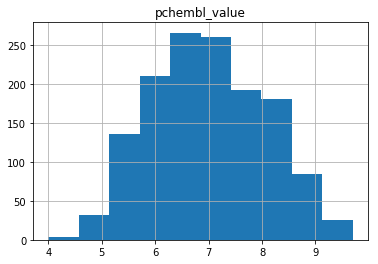

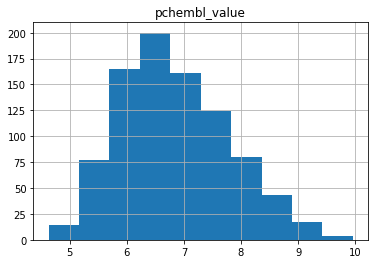

In [73]:
for v,k in tpls:
    if v>900:
        d.loc[d['target_chembl_id']==k].hist('pchembl_value');
        

Here's the function to build an evaluation a random forest for an assay. It's not the greatest model ever, but that's beside the point for this analysis

In [51]:
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def run_it(acts,inacts):
    act_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in acts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        act_data.append((acts['compound_chembl_id'].iloc[i],bv,1))


    inact_data = []
    for i,fp in enumerate(rdFingerprintGenerator.GetFPs([Chem.MolFromSmiles(x) for x in inacts['canonical_smiles']],fpType=rdFingerprintGenerator.MorganFP)):
        bv = np.zeros((len(fp),),np.int16)
        DataStructs.ConvertToNumpyArray(fp,bv)
        inact_data.append((inacts['compound_chembl_id'].iloc[i],bv,0))

    random.seed(0xf00d)
    nAct = len(act_data)
    actis = list(range(nAct))
    nInact = len(inact_data)
    inactis = list(range(nInact))
    random.shuffle(actis)
    random.shuffle(inactis)

    train_pct = 0.80
    train = [act_data[x] for x in actis[:int(train_pct*nAct)]] + [inact_data[x] for x in inactis[:int(train_pct*nInact)]]
    test = [act_data[x] for x in actis[int(train_pct*nAct):]] + [inact_data[x] for x in inactis[int(train_pct*nInact):]]

    random.shuffle(train)
    random.shuffle(test)

    cls = RandomForestClassifier(n_estimators=500,max_depth=15,min_samples_leaf=2,n_jobs=4)
    cls.fit([y for x,y,z in train],[z for x,y,z in train])
    scores = cls.predict([y for x,y,z in test])
    probs = cls.predict_proba([y for x,y,z in test])[:,1]
    auroc = metrics.roc_auc_score([z for x,y,z in test], probs)
    print('ratio: %.3f kappa: %.3f, AUC: %.3f'%(nAct/nInact,metrics.cohen_kappa_score([z for x,y,z in test],scores),auroc))
    print(metrics.confusion_matrix([z for x,y,z in test],scores))
    print(metrics.classification_report([z for x,y,z in test],scores))
    return probs,[z for x,y,z in test]

In [78]:
def run_assay(assay_id,d,assay_lookup,thresholds=[0.3]):
    assay = d.loc[d['target_chembl_id']==assay_id]
    acts = assay.loc[assay['pchembl_value']>9.0]
    if len(acts)<50:
        acts = assay.loc[assay['pchembl_value']>8.0]
        inacts = assay.loc[assay['pchembl_value']<7.5]
    else:
        inacts = assay.loc[assay['pchembl_value']<8.5]
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*')
    print(f'assay_id {assay_id}, organism: {assay_lookup[assay_id][0]}, target: {assay_lookup[assay_id][1]}')
    print("--------- Default -----------")
    ps,tgt = run_it(acts,inacts)
    print("--------- Balanced -----------")
    for thresh in thresholds:
        scores = [1 if x>=thresh else 0 for x in ps]
        print('thresh: %.3f kappa: %.3f'%(thresh,metrics.cohen_kappa_score(tgt,scores)))
        print(metrics.confusion_matrix(tgt,scores))
        print(metrics.classification_report(tgt,scores))
    print('*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n\n')


In [81]:
for v,k in tpls:
    if v>900:
        run_assay(k,d,assay_lookup,thresholds=[0.3,0.2,0.1])

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
assay_id CHEMBL3371, organism: Homo sapiens, target: Serotonin 6 (5-HT6) receptor
--------- Default -----------
ratio: 0.189 kappa: 0.657, AUC: 0.968
[[417  11]
 [ 31  50]]
             precision    recall  f1-score   support

          0       0.93      0.97      0.95       428
          1       0.82      0.62      0.70        81

avg / total       0.91      0.92      0.91       509

--------- Balanced -----------
thresh: 0.300 kappa: 0.790
[[408  20]
 [ 10  71]]
             precision    recall  f1-score   support

          0       0.98      0.95      0.96       428
          1       0.78      0.88      0.83        81

avg / total       0.94      0.94      0.94       509

thresh: 0.200 kappa: 0.714
[[390  38]
 [  7  74]]
             precision    recall  f1-score   support

          0       0.98      0.91      0.95       428
          1       0.66      0.91      0.77        81

avg / total       0.93      0.91      0.92       50